<a href="https://colab.research.google.com/github/KaizenGirl1111/guess_whose_painting/blob/master/guess%20painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time, os, copy, argparse
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d delayedkarma/impressionist-classifier-data


100% 2.18G/2.19G [00:25<00:00, 87.8MB/s]
100% 2.19G/2.19G [00:25<00:00, 90.6MB/s]


In [ ]:
!unzip impressionist-classifier-data.zip -d impressionist_dataset

Archive:  impressionist-classifier-data.zip
  inflating: impressionist_dataset/training/training/Cezanne/215457.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215458.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215459.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215460.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215462.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215463.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215466.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215467.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215468.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215469.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215470.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215471.jpg  
  inflating: impressionist_dataset/training/training/Cezanne/215473.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd

Number of painters: 10
Painter names: ['Gauguin', 'Matisse', 'VanGogh', 'Cezanne', 'Pissarro', 'Renoir', 'Degas', 'Sargent', 'Monet', 'Hassam']


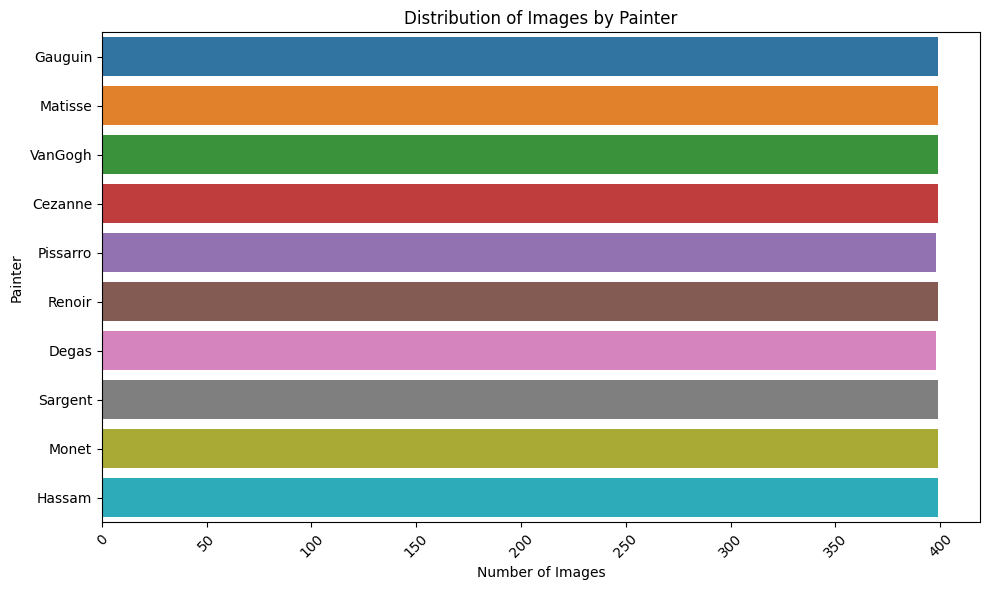

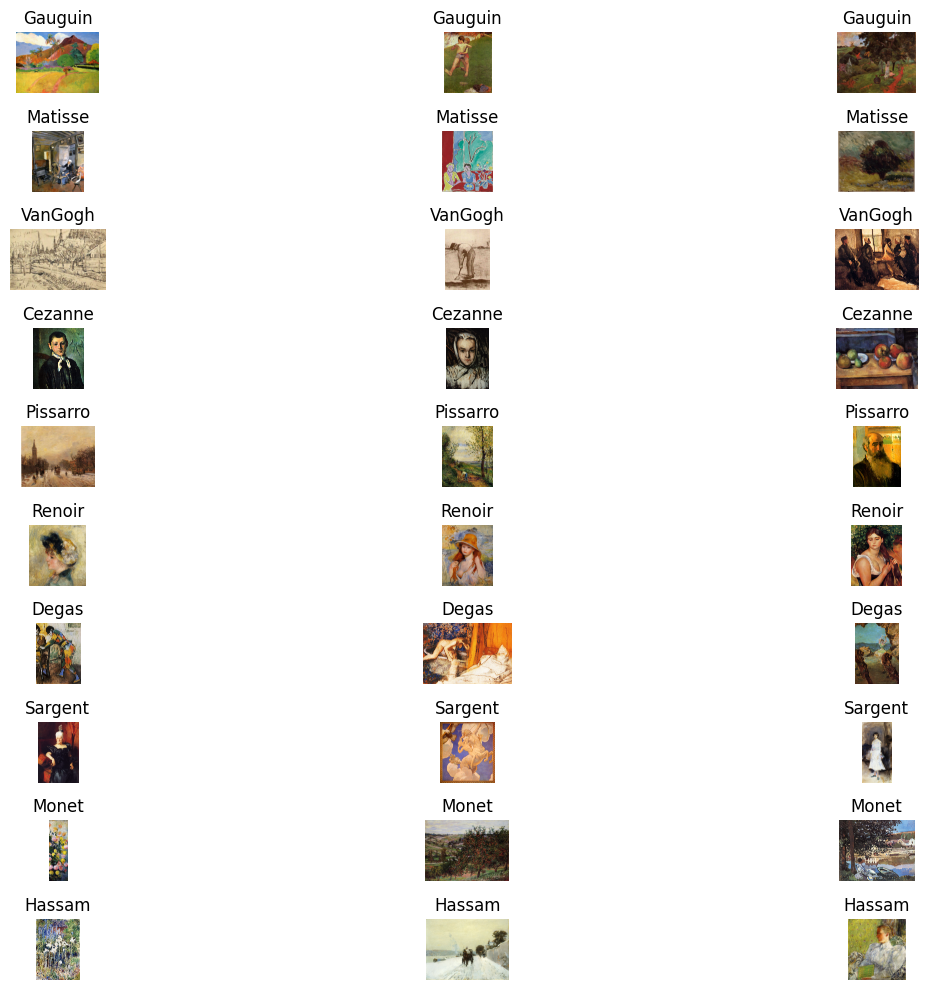

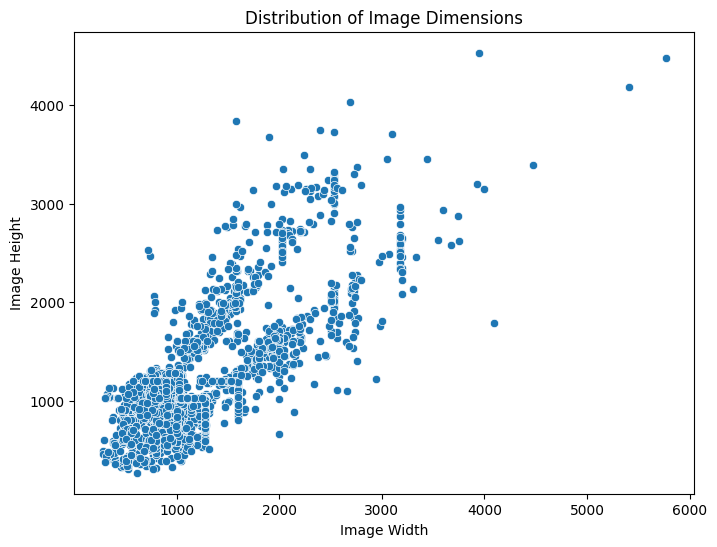

In [ ]:
  # Directory where the dataset is extracted

# Path to the dataset directory
# Path to the dataset directory
dataset_dir = 'impressionist_dataset'
training_dir = os.path.join(dataset_dir, 'training', 'training')  # Corrected path

# List of painters (class names)
painters = os.listdir(training_dir)
num_painters = len(painters)

print(f"Number of painters: {num_painters}")
print("Painter names:", painters)

# Distribution of images by painter
painter_counts = [len(os.listdir(os.path.join(training_dir, painter))) for painter in painters]

plt.figure(figsize=(10, 6))
sns.barplot(x=painter_counts, y=painters)
plt.xlabel("Number of Images")
plt.ylabel("Painter")
plt.title("Distribution of Images by Painter")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sample images from each painter
num_samples = 3

plt.figure(figsize=(15, 10))

for painter in painters:
    painter_dir = os.path.join(training_dir, painter)
    sample_images = os.listdir(painter_dir)[:num_samples]

    for idx, image_name in enumerate(sample_images):
        image_path = os.path.join(painter_dir, image_name)
        if os.path.isfile(image_path):  # Check if the path is a file
            image = Image.open(image_path)
            plt.subplot(num_painters, num_samples, idx + 1 + painters.index(painter) * num_samples)
            plt.imshow(image)
            plt.title(painter)
            plt.axis('off')

plt.tight_layout()
plt.show()

# Image dimensions
image_dimensions = []

for painter in painters:
    painter_dir = os.path.join(training_dir, painter)
    image_names = os.listdir(painter_dir)
    for image_name in image_names:
        image_path = os.path.join(painter_dir, image_name)
        if os.path.isfile(image_path):  # Check if the path is a file
            image = Image.open(image_path)
            width, height = image.size
            image_dimensions.append((width, height))

df_dimensions = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dimensions, x='Width', y='Height')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Distribution of Image Dimensions")
plt.show()

Epoch [1/2] - Train Loss: 0.1359 - Valid Loss: 0.0000
Epoch [2/2] - Train Loss: 0.0000 - Valid Loss: 0.0000


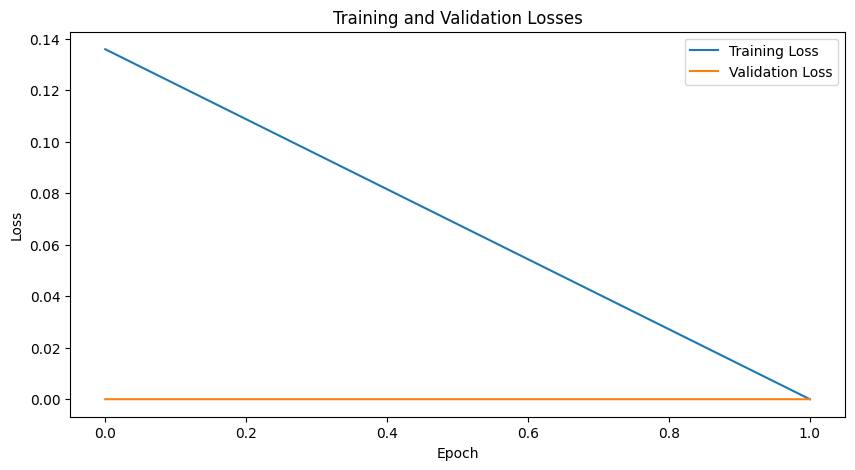

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Directories
train_directory = '/content/impressionist_dataset/training'
valid_directory = '/content/impressionist_dataset/validation'

# Hyperparameters
bs = 64
num_epochs = 2
num_classes = 10

# Image Transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load data from folders
train_dataset = datasets.ImageFolder(root=train_directory, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

# Split train_dataset into train and test sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)

# Class names
class_names = train_dataset.dataset.classes


# Model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store training and validation losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store average training loss for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    # Calculate and store average validation loss for this epoch
    valid_loss = running_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# ... (Code for plotting randomly selected test images and calculating accuracy)


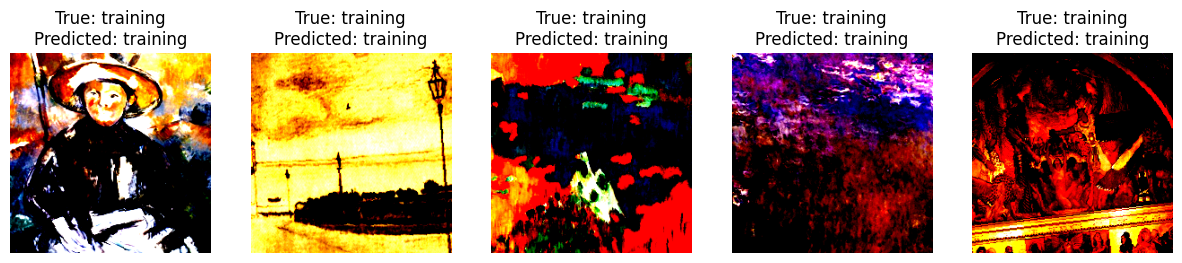

In [ ]:
# ... (Previous code)

# Display randomly selected test images and their predictions
model.eval()
num_samples = 5
random_indices = np.random.randint(0, len(test_dataset), num_samples)
plt.figure(figsize=(15, 7))
for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted_label = output.argmax().item()

    # Get the class names and class-to-index mapping
    original_classes = test_dataset.dataset.classes
    class_to_idx = test_dataset.dataset.class_to_idx

    # Get the actual class names from the class-to-index mapping
    true_class = original_classes[label]
    predicted_class = original_classes[predicted_label]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.show()

# ... (Rest of your code)



In [ ]:
torch.save(model.state_dict(), 'model_checkpoint.pth')

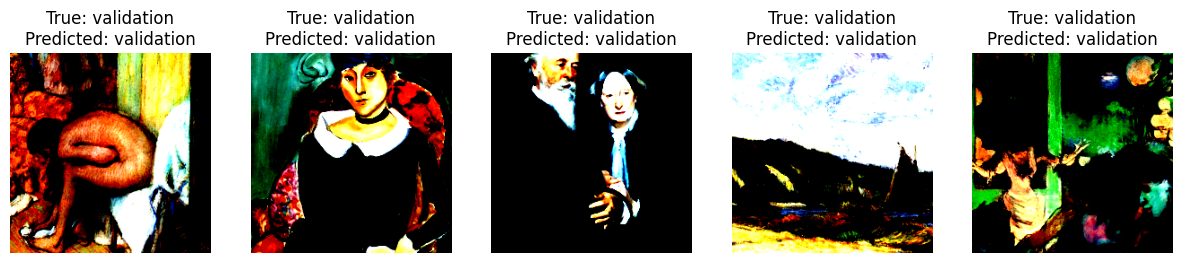

In [ ]:
# Display randomly selected validation images and their predictions
model.eval()
num_samples = 5
random_indices = np.random.randint(0, len(valid_dataset), num_samples)  # Use valid_dataset here
plt.figure(figsize=(15, 7))
for i, idx in enumerate(random_indices):
    image, label = valid_dataset[idx]  # Use valid_dataset here
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted_label = output.argmax().item()

    # Get the class-to-index mapping
    class_to_idx = valid_dataset.class_to_idx

    # Get the actual class name from the class-to-index mapping
    true_class_idx = label  # label is already the class index
    predicted_class_idx = predicted_label
    true_class = list(class_to_idx.keys())[list(class_to_idx.values()).index(true_class_idx)]
    predicted_class = list(class_to_idx.keys())[list(class_to_idx.values()).index(predicted_class_idx)]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.show()



In [ ]:
import torchvision
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
train_dataset = torchvision.datasets.ImageFolder(root='/content/impressionist_dataset/training', transform=transform)

# Create a DataLoader for the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Access class names from the dataset
class_names = train_dataset.classes

# Now you can use class_names for further processing


In [ ]:
# ... (previous code)

# Make predictions using the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(image)

print("Model output:", output)  # Print the output tensor for debugging

# Load class names
class_names = ["Cezanne", "Degas", "Gauguin", "Hassam", "Matisse", "Monet", "Pissarro", "Renoir", "Sargent", "VanGogh"]

# Check model output dimensions
print("Number of predicted classes:", output.shape[1])
print("Number of class names:", len(class_names))

# Get predicted class index
predicted_class_idx = torch.argmax(output).item()

# Check if predicted_class_idx is within valid range
if predicted_class_idx < len(class_names):
    predicted_class = class_names[predicted_class_idx]
    print("Predicted class:", predicted_class)
else:
    print("Predicted class index out of range.")













Model output: tensor([[14.3530, -1.4484, -1.3895, -1.5701, -1.6110, -0.7042, -1.5381, -1.3621,
         -1.0494, -1.3242]])
Number of predicted classes: 10
Number of class names: 10
Predicted class: Cezanne


ValueError: ignored

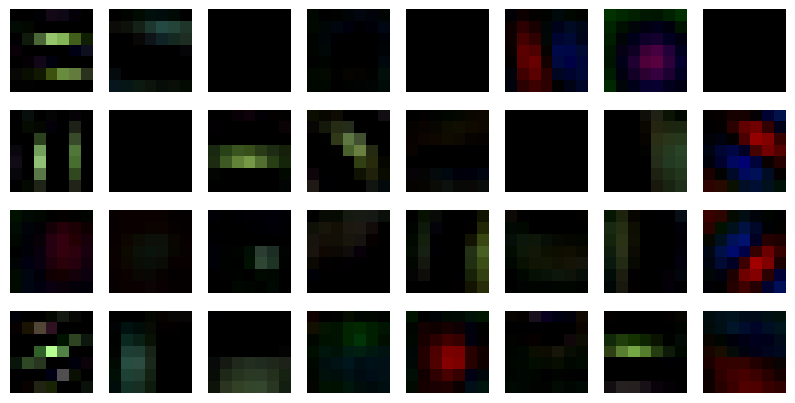

In [ ]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
conv1_weights = model.conv1.weight.data

# Plot conv1 layer filters
plt.figure(figsize=(10, 5))
for i in range(conv1_weights.shape[0]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(np.transpose(conv1_weights[i].cpu(), (1, 2, 0)))
    plt.axis('off')
plt.suptitle('Conv1 Layer Filters')
plt.show()

# Choose a higher convolutional layer (e.g., layer3)
higher_layer_weights = model.layer3[0].conv1.weight.data

# Plot filters of the higher convolutional layer
plt.figure(figsize=(10, 5))
for i in range(higher_layer_weights.shape[0]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.transpose(higher_layer_weights[i].cpu(), (1, 2, 0)))
    plt.axis('off')
plt.suptitle('Higher Convolutional Layer Filters')
plt.show()

# Visualization of activations can be done using a library like torchvision's utils
from torchvision import utils

def plot_activations(activation):
    plt.figure(figsize=(10, 5))
    plt.imshow(utils.make_grid(activation, nrow=8, padding=2).cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

# Pass an image through the model and get activations from a chosen layer
model.eval()
input_image = ...  # Load and preprocess an input image
with torch.no_grad():
    activations = model.layer3[0](input_image)

# Plot the activations
plot_activations(activations)